# Planet Hunting
### Michael Frasco

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import matplotlib.patches as mpatches
import pickle
import urllib2

In [2]:
def parse(a):
    # input: information about the light curve
    # output: the points of time where the light flux is measured,
        # the values of the light flux, the light curve ID,
        # and an indicator of whether this curve is the right length
        
    time = np.array(a['data'][0:4757])
    flux_raw = np.array(a['data'][4757:])
    lc_id = a['id']
    keep = len(flux_raw) == 4757
    return {'time':time, 'flux_raw':flux_raw, 'lc_id':lc_id, 'keep':keep}

In [3]:
lc = sc.textFile('s3n://stat-37601/lightcurves.json').map(lambda x: parse(json.loads(x)))
lc = lc.filter(lambda x: x['keep']) # only take the valid light curves

In [4]:
# these are given values
gap = 0.0204
N = 4757
sz = (N - 1) / 2
u = np.arange(-gap*sz, gap*(sz+1), gap, dtype=np.float64)

In [5]:
def kernel_epa(u):
    # input: the gaps between points in an array
    # output: the implementation of the Epanachnikov kernel
    
    w = (abs(u) <= 1) * (1 - u*u)
    return w[w > 0]

def kernel_tri(u):
    # input: the gaps between points in an array
    # output: the implementation of the tricube kernel
    w = (abs(u) <= 1) * (1 - abs(u*u*u))
    return w[w > 0]

In [6]:
def BuildKernelWeights(kernel, u, h):
    # a wrapper function that takes into account the bandwidth
    
    if kernel == "epa":
        w = kernel_epa(u / h)
    elif kernel == "tri":
        w = kernel_tri(u / h)
    return w

In order to deal with the NAN values in the flux arrays, I performed the following data-cleaning steps. First, I would the indicies of all of the NAN values. Then I replaced those NAN values with zero. As a result, when we are computing the convolution of the kernel values and the flux values, the observations that were NAN will not have an impact (i.e. the kernel value is being multiplied by zero). For this same reason, I needed to replace the corresponding indicies in my array of all ones with zero so that I can accurately compute the denominator of the kernel regression prediction. Notice that the "constant" term is no longer constant because each light curve has different NAN values.

In [7]:
def CorrectNAN(flux_raw):
    # input: the raw values of the flux with NAN
    # output: the values of the flux with zeros instead of NANs
        # and a vector indicating the location of the non-NAN values
    
    nan_indicator = np.isnan(flux_raw)
    nan_indicies = np.where(nan_indicator)
    real_indicies = np.where(np.logical_not(nan_indicator))
    flux_zero = np.nan_to_num(flux_raw)
    ones = np.ones(len(flux_zero), dtype=np.float64)
    ones[nan_indicies] = 0
    return {'real_indicies':real_indicies, 'flux_zero':flux_zero, 'ones':ones}

In [8]:
def MakePredictions(w, ones, flux_zero, real_indicies):
    # input: the vector of kernel values, a vector of ones, a vector of flux values
        # where the indicies correspoinding to NAN are replaced with zero
        # a vector of indicies where the observations are not NAN
    # output: A dictionary of the constant vector and the prediction vector
    
    const = np.convolve(w, ones, 'same')
    const = const[real_indicies]
    yhat = np.convolve(w, flux_zero, 'same')
    yhat = yhat[real_indicies] / const
    return {'const':const, 'yhat':yhat}

def GetCVRisk(const, yhat, flux):
    # input: the constant term, the predictions, and the true values
    # output: the risk
    
    LOO_term = 1 - (np.reciprocal(const))
    error = (flux - yhat) / LOO_term
    return np.mean(error ** 2)

In [9]:
lc_corrected = lc.map(lambda x: {'time':x['time'], 'flux_raw':x['flux_raw'], 'lc_id':x['lc_id'],
                                 'corrected':CorrectNAN(x['flux_raw'])})

##### Epanachnikov Cross Validation

In [10]:
risks = []
for h in [0.01, 0.05, 0.1, 0.25, 0.5, 0.7]:
    w = BuildKernelWeights("epa", u, h)
    lc_mapped = lc_corrected.map(lambda x: {'correct_flux':x['flux_raw'][x['corrected']['real_indicies']],
                                      'predictions':MakePredictions(w, x['corrected']['ones'],
                                                                    x['corrected']['flux_zero'],
                                                                    x['corrected']['real_indicies'])})
    lc_mapped = lc_mapped.map(lambda x: GetCVRisk(x['predictions']['const'],
                                                  x['predictions']['yhat'],
                                                  x['correct_flux']))
    risks.append(lc_mapped.mean())

In [11]:
risks

[nan,
 2164888.5042730654,
 7911439.0285247071,
 27773806.576431107,
 50613360.767011948,
 45975130.414081998]

The reason that the bandwidth of 0.01 gives a nan value is that the kernel for such a small bandwidth is only 1 point wide. So leave one out cross validation results in dividing by zero.

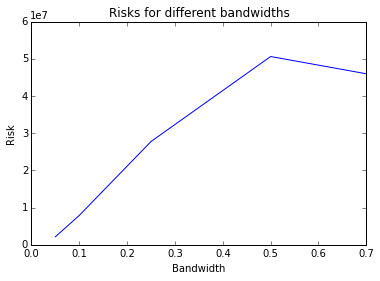

In [13]:
plt.plot([0.01, 0.05, 0.1, 0.25, 0.5, 0.7], risks)
plt.title("Risks for different bandwidths")
plt.xlabel("Bandwidth")
plt.ylabel("Risk")
plt.show()

The optimal bandwidth as calculated by leave-one-out cross validation is 0.05. I was surprised to find that such a small bandwidth performed the best. At first, I suspected that I was calculating the leave-one-out risk incorrectly. However, after double checking my implementation, the results above were confirmed by the fact that the bandwidth of 0.05 maximizes the area under the precision-recall curve. Using the Epanachnikov kernel with a bandwidth of 0.05 means that only the nine surrounding points are included in every estimate. We would expect this would reduce the size of the residuals for the transit points, thereby preventing us from indentifying transits. However, the reason that this bandwidth actually works is that the estimates for non-transit points are so small that, in comparison, the transit residuals are huge.

##### Tricube Cross Validation

In [14]:
risks = []
for h in [0.01, 0.05, 0.1, 0.25, 0.5, 0.7]:
    w = BuildKernelWeights("tri", u, h)
    lc_mapped = lc_corrected.map(lambda x: {'correct_flux':x['flux_raw'][x['corrected']['real_indicies']],
                                      'predictions':MakePredictions(w, x['corrected']['ones'],
                                                                    x['corrected']['flux_zero'],
                                                                    x['corrected']['real_indicies'])})
    lc_mapped = lc_mapped.map(lambda x: GetCVRisk(x['predictions']['const'],
                                                  x['predictions']['yhat'],
                                                  x['correct_flux']))
    risks.append(lc_mapped.mean())

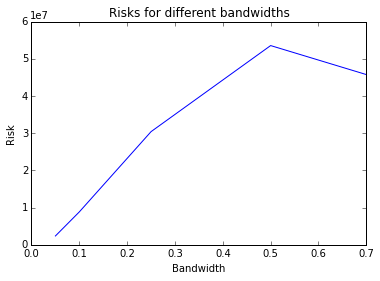

In [16]:
plt.plot([0.01, 0.05, 0.1, 0.25, 0.5, 0.7], risks)
plt.title("Risks for different bandwidths")
plt.xlabel("Bandwidth")
plt.ylabel("Risk")
plt.show()

The shape of the graph is very similar.

In [17]:
risks

[nan,
 2373989.4896401977,
 8846370.1274472736,
 30421687.136923708,
 53555997.577602543,
 45764801.588125497]

We see from the above that the minimum value is once again the 0.05 bandwidth. However, the tricube minimum is not as low as the Epanachnikov minimum.

##### Residual Analysis

In [10]:
w_best = BuildKernelWeights("epa", u, 0.05)

In [11]:
lc_mapped = lc_corrected.map(lambda x: {'correct_flux':x['flux_raw'][x['corrected']['real_indicies']],
                                  'lc_id':x['lc_id'],
                                  'predictions':MakePredictions(w_best, x['corrected']['ones'],
                                                                x['corrected']['flux_zero'],
                                                                x['corrected']['real_indicies'])})
lc_residual = lc_mapped.map(lambda x: {'res':np.array(x['correct_flux']) - np.array(x['predictions']['yhat']),
                                       'lc_id':x['lc_id']})

In [12]:
def StandardizeRes(res):
    # input: the residuals
    # output: the standardized residuals
    
    med = np.median(res)
    res_med = abs(res - med)
    sigma = np.median(res_med) * 1.4826
    res_mean = np.mean(res)
    res = res - res_mean
    return res / sigma

In [13]:
def ThresholdRes(res, constant):
    # I want to experiment with the constant term to see if that affects my results
    
    beta = np.sqrt(constant * np.log(len(res)))
    return (res >= -beta) * res

In [14]:
def GetNorm(res, order):
    return np.linalg.norm(res, order)

In [24]:
def prcurve(ranking, positives, curvetitle, plot):
    """
    Display the precision-recall curve and 
    compute the area under it. (See `prcurve_1` and `prcurve_2`.)
    """

    # Change ID formats
    mapping = pickle.load(urllib2.urlopen("https://s3.amazonaws.com/ml-lightcurves-q14/mapp.pickle"))
    as_dict = dict([(y, x) for (x, y) in mapping])
    ranking = [as_dict.get(x, None) for x in ranking]
    as_dict = None
    mapping = None

    # Precision-recall
    precision = []
    recall = []
    count = 0.0
    N = len(positives)
    for i, ID in enumerate(ranking):
        if ID in positives:
            count += 1.0
            precision.append( count/(i+1) )
            recall.append( count/ N )
        if count == N:
            break

    a = np.array(precision, dtype=np.float32)
    area = np.sum(a / N)

    if plot:
        plt.plot(recall, precision, '-r', linewidth=2)
        plt.xlabel('recall', fontsize=15)
        plt.ylabel('precision',fontsize=15)
        plt.xlim((-0.01,1.01))
        plt.title('{} area = {}'.format(curvetitle, area), fontsize=15)
        plt.show()

    return area

def prcurve_1(ranking, plot):
    """
    PART I: detect confirmed or eclipsing binary stars
    """
    conf_and_eb_id = [int(i) for i in 
                      urllib2.urlopen('https://s3.amazonaws.com/ml-lightcurves-q14/conf_and_eb_id.txt')]
    conf_cand_eb_id = [int(i) for i in
                       urllib2.urlopen('https://s3.amazonaws.com/ml-lightcurves-q14/conf_cand_eb_id.txt')]
    
    return (prcurve(ranking, conf_and_eb_id, "conf+eb", plot),
            prcurve(ranking, conf_cand_eb_id, "conf&cand+eb", plot))

def prcurve_2(ranking, plot):
    """
    PART II: detect confirmed stars
    """
    conf_id = [int(i) for i in 
               urllib2.urlopen('https://s3.amazonaws.com/ml-lightcurves-q14/conf_id.txt')]
    conf_and_cand_id = [int(i) for i in 
                        urllib2.urlopen('https://s3.amazonaws.com/ml-lightcurves-q14/conf_and_cand_id.txt')]
    
    return (prcurve(ranking, conf_id, "conf", plot),
            prcurve(ranking, conf_and_cand_id, "conf&cand", plot))

In [16]:
lc_standardized = lc_residual.map(lambda x: {'res':StandardizeRes(x['res']), 'lc_id':x['lc_id']})

In [38]:
for constant in [1, 2, 4]:
    for order in [1, 2, np.inf]:
        lc_norms = lc_residual.map(lambda x: (GetNorm(ThresholdRes(x['res'], constant), order), x['lc_id']))
        lc_ranked = lc_norms.sortByKey(ascending=False)
        
        # since we have 166,000 stars, but only 1.5% are planets or eclipsing binaries, 
        # we only need to look at the first 5,000 entries in our ranked list
        ranked = lc_ranked.take(5000)
        ranked_id = [lc[1] for lc in ranked]
        print prcurve_1(ranked_id, False)

(0.13974637, 0.072376058)
(0.15944156, 0.082611471)
(0.13839498, 0.072305843)
(0.13979094, 0.072398752)
(0.15944271, 0.082612067)
(0.13839498, 0.072305843)
(0.14005545, 0.072534963)
(0.15944511, 0.082613289)
(0.13839498, 0.072305843)


This is strange. I swear that I got areas of 0.35 and 0.21 with constant=2 and order=1 before I decided to put the code in a giant for-loop that took 90 minutes to run. Huh.

##### Planets Vs. Eclipsing Binaries

My intuition suggests that in order to differentiate between stars with planets and eclipsing binary star systems, there are two observations we can use. The first, which was provided in the assignment, is the fact that the reduction in light during an occultation of a binary star system will be much greater than the reduction in light for a planetary transit. This is because when the two stars are not blocking each other, they are both giving off light. The other observation is that in eclipsing binary star system there should also be a slight, periodic increase in the light curve. This is because when both stars are not blocking each otherm there will be a surge of light.

My strategy will be to take the product of the magnitude of the minimum residual and the maximum residual. For eclipsing binary star systems, this product should be very large. I will also take the average of the ten largest and ten smallest residuals, in order to get a robust estimate.

In [27]:
def MaxTimesMin(res):
    max_res = max(res)
    min_res = min(res)
    return max_res * min_res

def RobustMaxMin(res):
    sorted_res = sorted(res)
    max_res = np.mean(sorted_res[-10:])
    min_res = np.mean(sorted_res[:10])
    return max_res * min_res

In [31]:
lc_ranked = lc_standardized.map(lambda x: (MaxTimesMin(x['res']), x['lc_id'])).sortByKey()
ranked = lc_ranked.take(5000)
ranked_id = [lc[1] for lc in ranked]

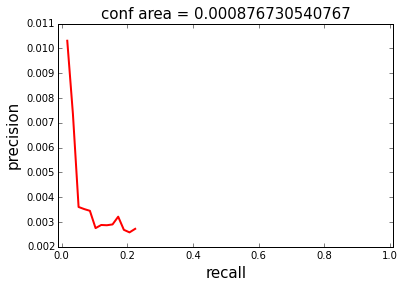

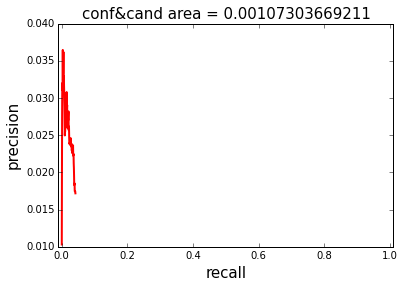

(0.00087673054, 0.0010730367)

In [32]:
prcurve_2(ranked_id[::-1], True)

Wow, that wasn't very good.

In [28]:
lc_ranked = lc_standardized.map(lambda x: (RobustMaxMin(x['res']), x['lc_id'])).sortByKey()
ranked = lc_ranked.take(5000)
ranked_id = [lc[1] for lc in ranked]

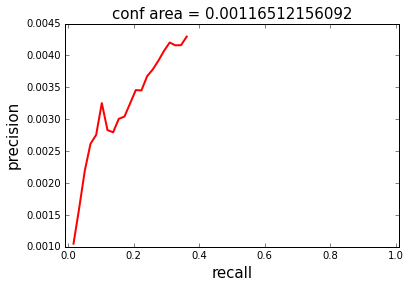

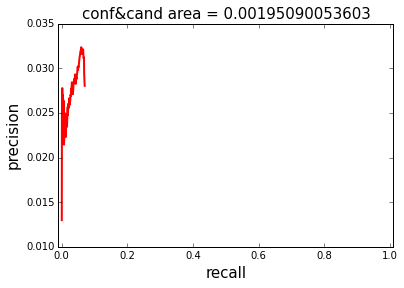

(0.0011651216, 0.0019509005)

In [30]:
prcurve_2(ranked_id[::-1], True)